<a href="https://colab.research.google.com/github/tamalmisra/DeepfakeImageDetection/blob/main/DeepfakeWithImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 16 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Class Indices: {'fake': 0, 'real': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5000 - loss: 0.6961
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5000 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5625 - loss: 0.6851
Epoch 2: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5625 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4375 - loss: 0.6940
Epoch 3: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4375 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5625 - loss: 0.6904
Epoch 4: val_accuracy did not improve from 0.50000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2

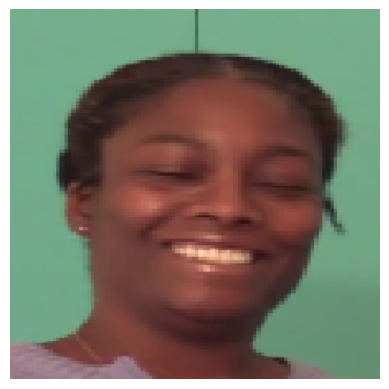

The image is classified as: Real (Confidence: 71.08%)


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt  # Added for displaying images

# Step 1: Prepare the dataset paths
train_dir = "/content/drive/MyDrive/split_dataset/train"  # Replace with your training dataset path
test_dir = "/content/drive/MyDrive/split_dataset/test"    # Replace with your testing dataset path
val_dir = "/content/drive/MyDrive/split_dataset/val"      # Replace with your validation dataset path

# Step 2: Use ImageDataGenerator to load and preprocess images
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1.0 / 255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Binary classification (real or fake)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Do not shuffle for evaluation
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Print class indices to verify the mapping
print("Class Indices:", train_generator.class_indices)

# Step 3: Load and modify the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')  # Binary classification (fake or real)
])

# Step 4: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Add callbacks
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Use the new Keras format
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Step 6: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Step 7: Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 8: Fine-tune the model by unfreezing some layers
base_model.trainable = True
for layer in base_model.layers[:100]:  # Unfreeze the first 100 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Step 10: Save the trained model
model.save("fake_image_detector_finetuned.keras")  # Use the new Keras format

# Step 11: Load the trained model and use it for predictions
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("fake_image_detector_finetuned.keras")

# Step 12: Evaluate the model on the test dataset
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"], zero_division=0))  # Handle zero division

# Step 13: Function to predict if an image is fake or real and estimate the percentage difference
def predict_image(img_path, threshold=0.5):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Make prediction
    prediction = model.predict(img_array)
    confidence = prediction[0][0]  # Probability of being "real" (class 1)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Map prediction to class label
    if confidence > threshold:
        return f"Real (Confidence: {confidence * 100:.2f}%)"
    else:
        return f"Fake (Confidence: {(1 - confidence) * 100:.2f}%)"

# Test the function
image_path = "/content/drive/MyDrive/split_dataset/test/real/abarnvbtwb-002-00.png"  # Replace with your test image path
result = predict_image(image_path, threshold=0.5)  # Adjust threshold as needed
print(f"The image is classified as: {result}")